In [23]:
# In[135]:


import sys
import time
from collections import Counter
import math

import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path 


In [16]:
# In[136]:


# the location of the current directry

path = os.getcwd()
print(path)
print(type(path))


/Users/hiroki/Documents/大学/AIC/一貫校/高速FBシステム
<class 'str'>


In [17]:
# csvファイルの読み込み

# 使い方!!!!!!!!(必読)
# current directryにcsv_fileというフォルダを作る
# 得られたデータセットは全てそこに入れる
# あとは回すだけコードを回すのみ!

p = Path('./csv_file') #current directry
file_name = '**/*.csv'
csv_files = p.glob(file_name)


# 年月日時分秒の入力
zero = '.000'

input_start_time = input("サッカーを開始した年月日時分秒を入力してください (YYYY-MM-DD HH:MM:SS): ")
input_goal_time = input("サッカーを終了した年月日時分秒を入力してください (YYYY-MM-DD HH:MM:SS): ")

start_time = input_start_time + zero
end_time = input_goal_time + zero

# 開始時間と終了時間
# start_time = '2023-06-13 16:20:02.000'
# end_time = '2023-06-13 16:40:02.000'

def main():   
    name = {}
    count = 0       
    for file in csv_files:
        # 緯度, 経度の読み込み
        df1 = pd.read_csv(file,dtype='object',usecols=[0, 2, 3]).dropna(how='all')

        # print(df1)

        # 列名を変更する
        df1.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
        # 一列目の時間をindexにする
        df1.set_index('Time', inplace=True)

        # インデックスの範囲を指定してデータをフィルタリング
        filtered_df1 = df1.loc[start_time:end_time] 
        
        name["location" + str(count)] = np.float_(filtered_df1.values) # 適当に名前つけちゃう
        count = count + 1 # roop counter
        
        # 動作確認パート
        #print(file)  # ファイル名
        #print(df1)   # 中身
        #print(count) # 実行回数
        #print(name["location" + str(count - 1)])
        #print(name)
        
    return name
        
if __name__ == '__main__':
    name = main()

#print(name)

In [18]:
# 初期設定

# 手動入力

NW_E = 139.5460865  #初等部グラウンド北西(経度)
NW_N = 35.5606717   #初等部グラウンド北西(緯度)

SE_E = 139.5476025  #初等部グラウンド南東(経度)
SE_N = 35.5599487   #初等部グラウンド南東(緯度)

def caluculate_coordinate(NW_E, NW_N, SE_E, SE_N):


    com = round(np.abs(NW_E-SE_E)/np.abs(NW_N-SE_N)*10)/10 #ざっくり縦横比(南北を1とした時の東西の値)

    r2 = 40              #解像度(南北)
    c2 = int(r2*com)     #解像度(東西)　ここを任意で指定する場合, plt.axes().set_aspect('equal')を削除すること!

    # 付随する変数もろもろ
    w = (SE_E - NW_E)/c2
    h = (NW_N - SE_N)/r2
    ground = np.zeros((c2,r2))
    sam = np.zeros((c2,r2))

    return r2, c2, w, h, ground, sam

In [19]:
# ヒートマップ作成
def generate_heatmap(name, NW_E, NW_N, w, h, c2, r2, ground, sam):

    amount = len(name) #読み込んだデータの数(生徒数)

    for n in range(amount):
        location = name["location" + str(n)]
        size = location.shape[0]

        for i in range(size):
            x = math.floor((location[i][1]-NW_E)/w)
            y = math.floor(-(location[i][0]-NW_N)/h)
            
            if x>c2 or x<0:   # グラウンド外を指したデータの削除
                pass
            elif y>r2 or y<0: # グラウンド外を指したデータの削除
                pass
            else:
                ground[x][y] = ground[x][y] + 1

        for i in range(1,c2-2):
            for j in range(1,r2-2):
                sam[i][j] = sam[i][j] + (ground[i+1][j-1] + ground[i+1][j] + ground[i+1][j+1] 
                            + ground[i][j-1] + ground[i][j] + ground[i][j+1] 
                            + ground[i-1][j-1] + ground[i-1][j] + ground[i-1][j+1])/9
    return sam

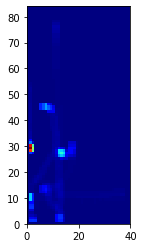

In [21]:
r2, c2, w, h, ground, sam = caluculate_coordinate(NW_E, NW_N, SE_E, SE_N)
sam = generate_heatmap(name, NW_E, NW_N, w, h, c2, r2, ground, sam)


# 描画(左が北, 上が東)

xline = np.linspace(1,c2,c2)
yline = np.linspace(1,r2,r2)
zline = sam
plt.axes().set_aspect('equal') # サイズ合わせ

plt.pcolor(zline, cmap='jet')

# 保存先のディレクトリを指定
save_directory = "heatmaps"  # 保存先のディレクトリ名

# グラフを指定したディレクトリに保存
file_path = os.path.join(save_directory, "heatmap_whole.pdf")  # 保存するファイルのパス

plt.savefig(file_path)
plt.show()
